in questo ese non quadrano i prediction interval del next process outcome finali nonostante il modello sia lo stesso 

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda
import myfunc as mf

# Import the dataset
data = pd.read_csv('240606_ex1.csv')

# Inspect the dataset
print(data.head())
print(data.info)

   Sample  Concentration
0       1           8.36
1       2          12.72
2       3           8.60
3       4           7.72
4       5           5.97
<bound method DataFrame.info of     Sample  Concentration
0        1           8.36
1        2          12.72
2        3           8.60
3        4           7.72
4        5           5.97
5        6           5.43
6        7           4.32
7        8           5.58
8        9           4.59
9       10           6.94
10      11           3.56
11      12           7.71
12      13           1.57
13      14           7.32
14      15           3.95
15      16           6.31
16      17          -0.23
17      18          -0.35
18      19           3.23
19      20           7.38
20      21           4.73
21      22           7.96
22      23          11.58
23      24          14.99
24      25           8.21
25      26           8.83
26      27           7.54
27      28          12.35
28      29           6.27
29      30           8.68
30      31  

Number of points n = 50
Mean = 10.11


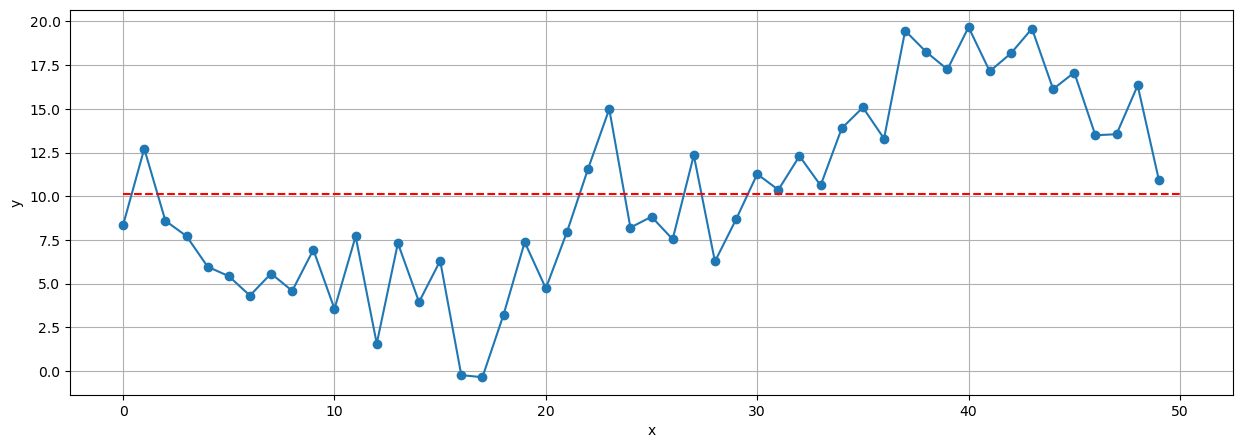

In [2]:
mf.single_ts_plot(data['Concentration'])

p-value of the Shapiro-Wilk test: 0.223


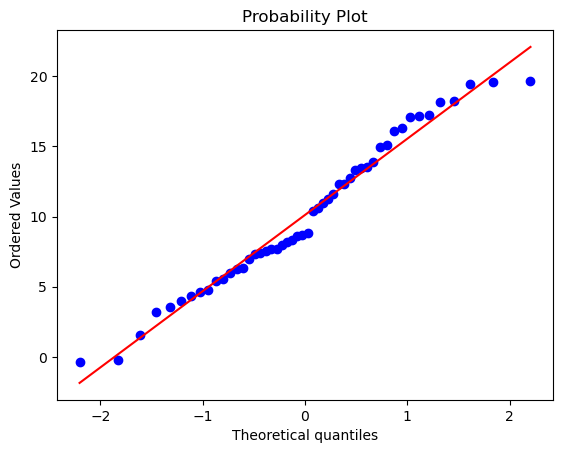

Accept H0: the data are normal


In [3]:
mf.shapiroqq(data['Concentration'])

In [4]:
mf.runs(data['Concentration'],0.05)

Runs test statistic = -5.141
Runs test p-value = 0.000
Reject H0: the data are not random


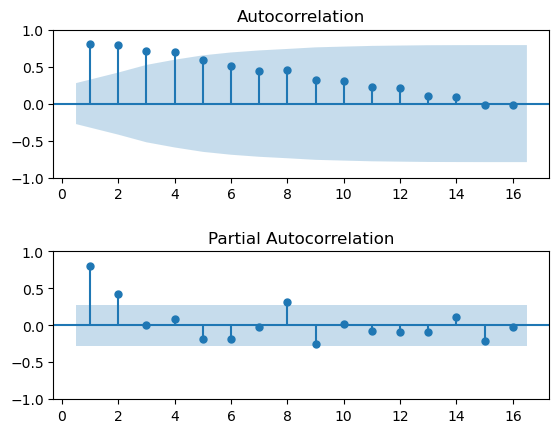

In [5]:
mf.acfpacf(data['Concentration'])

In [6]:
data['dummy'] = np.zeros(len(data))
data['dummy'][16:18] = 1


c:\Users\alyuk\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
data['lag1'] = data['Concentration'].shift(1)

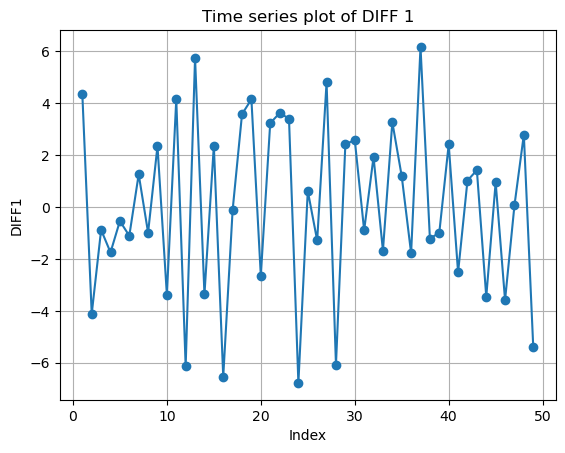

Runs test statistic = 3.036
Runs test p-value = 0.002
Reject H0: the data are not random


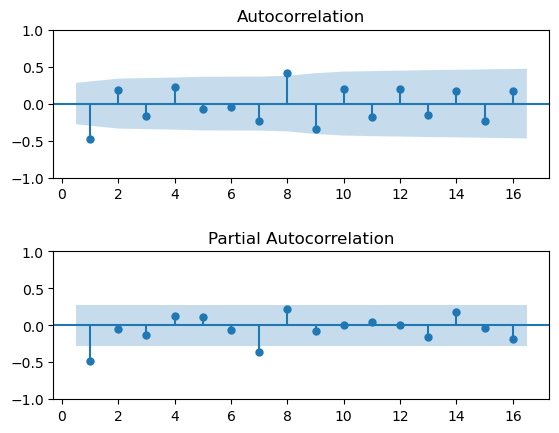

In [8]:
data['diff_1']=mf.diffprocess (data,'Concentration','lag1',1)

In [9]:
data['diff1_lag1'] = data['diff_1'].shift(1)

import statsmodels.api as sm
import qda
regress1=data['diff1_lag1'].iloc[2:]
regress2=data['dummy'].iloc[2:]
data4reg = pd.DataFrame({'diff_lag1': regress1, 'dummy': regress2})
x = data4reg[['diff_lag1', 'dummy']]#se solo un regressore togli le doppie quadre e metti singole
y = data['diff_1'].iloc[2:]

model = sm.OLS(y, x).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
diff_1 =  -0.540 diff_lag1 -4.459 dummy

COEFFICIENTS
------------
     Term    Coef  SE Coef  T-Value    P-Value
diff_lag1 -0.5401   0.1235  -4.3740 6.9315e-05
    dummy -4.4589   1.9785  -2.2537 2.9023e-02

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
2.7633 0.3237     0.2943

ANALYSIS OF VARIANCE
---------------------
    Source   DF   Adj SS   Adj MS  F-Value    P-Value
Regression  2.0 169.4052  84.7026  11.0068 1.2409e-04
 diff_lag1  1.0 147.2274 147.2274  19.1316 6.9315e-05
     dummy  1.0  39.0870  39.0870   5.0792 2.9023e-02
     Error 46.0 353.9933   7.6955      NaN        NaN
     Total 48.0 523.3985      NaN      NaN        NaN


Shapiro-Wilk test p-value on the residuals = 0.346


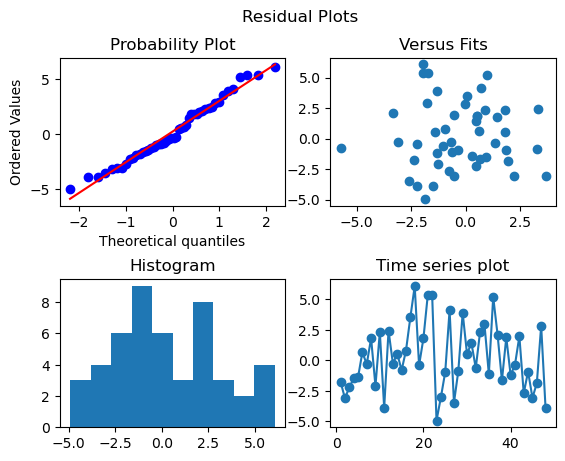

In [10]:
mf.shapirplusresplots(model, salta=0)

In [11]:
mf.runs(model.resid)

Runs test statistic = 1.225
Runs test p-value = 0.221
Accept H0: the data are random


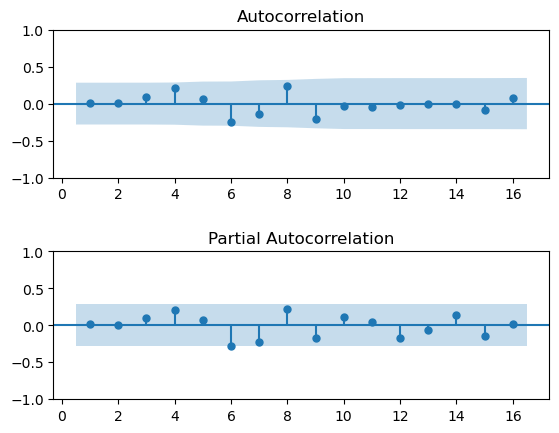

In [12]:
mf.acfpacf(model.resid)

In [13]:
residual=model.resid

In [14]:
last_lag = data4reg['diff_lag1'].iloc[-1]
last_dummy=data4reg['dummy'].iloc[-1]
prediction_df = model.get_prediction([last_lag,last_dummy]).summary_frame(alpha=0.05)
print(prediction_df)
#ad ogni risultato tranne mean_se però va aggiunto l'ultimo sample (a causa della differenziazione)

    mean  mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0 -1.507   0.3445        -2.2005        -0.8135       -7.1338        4.1198


In [15]:
bla=-0.540*(data['lag1'].iloc[-1]-data['lag1'].iloc[-2])
lower=bla-0.3445*stats.norm.ppf(1-0.05/2)

point3

In [16]:
ARL0=250
alfa=1/ARL0

In [17]:
k_alfa=stats.norm.ppf(1-alfa/2)

In [18]:
print(np.mean(model.resid))


0.23871230470610416


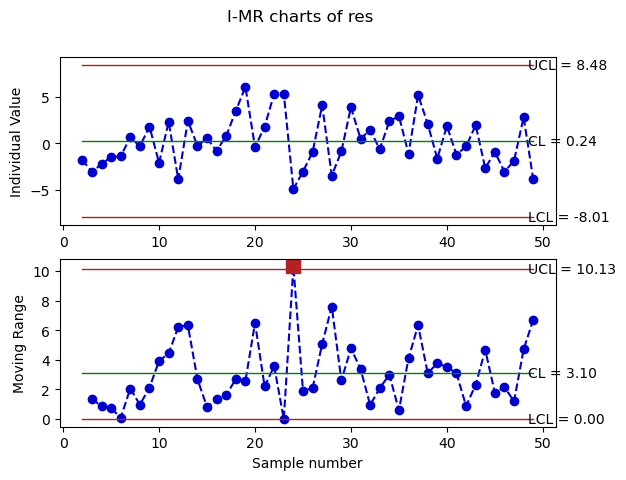

In [19]:
df_SCC = pd.DataFrame({'res': model.resid}) #lo chiamo direttamente df_SCC
df_SCC = qda.ControlCharts.IMR(df_SCC, 'res')


qui viene che MR presenta OOC, potrebbe essere per la violazione di normalità! proviamo ad ovviare!
la mia funzione fa tutto automaticamente :)

Lambda = 0.479
p-value of the Shapiro-Wilk test: 0.955
box cox succeeded :)


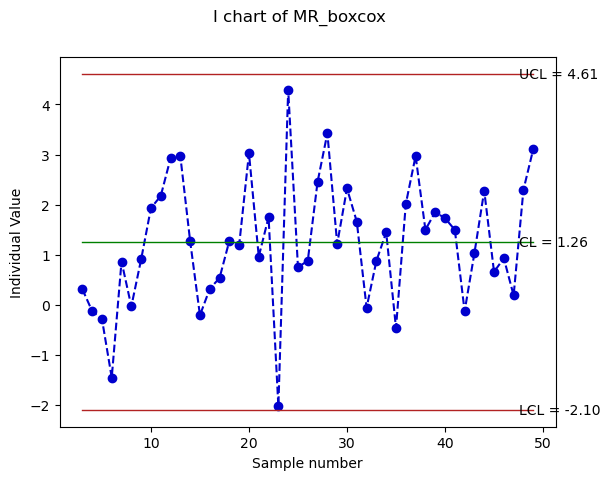

In [20]:
df_MR_boxcox=mf.IonMRresBoxCox(df_SCC)

From historical data, it is known that the most appropriate model for this process yielded a standard 
deviation of residuals equal to 𝜎𝜀 = 2.5. Determine, with a statistical test, if the model fitted at point a) is 
such that the standard deviation of residuals is greater than this value (report also the p-value of the test). 
Discuss the result. 

In [21]:
sigma_e=2.5
sigma2_e=sigma_e**2
residual_standard_error = np.sqrt(model.mse_resid)

In [22]:
model.mse_resid

7.695506581255311

In [23]:
dof=48-2
[chi2,critical_values,p_value]=mf.chi2_test(model.mse_resid,sigma2_e,dof,direction='greater',alpha=0.05)

critical value is 62.830

p_value is 0.135

we have to accept
